## Notebook to generate a parametric dataset for 1D Burgers' equation using an analytic solution

In [1]:
## Load modules
import numpy as np
from numpy import array
import scipy
from scipy.special import erf
import os
import sys
import gc
# import argparse
import time
import importlib
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':12,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','D','H',])

from pathlib import Path
try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent 

data_dir = base_dir / "data" / "burgers1d"
fig_dir  = base_dir / "figures"
scripts_dir  = base_dir / "scripts"
work_dir = base_dir / "Burgers"

Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(fig_dir).mkdir(parents=True, exist_ok=True)

sys.path.append(str(scripts_dir.absolute()))

import data_utils as du



Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$.

In [2]:
### Define problem parameters
L = 1
tmax = 2

Re_list = [50, 150, 300, 500, 400, 600]

### Create a uniform grid
Nx = 200
Nt = 500
xx = np.linspace(0,L,Nx)
tt = np.linspace(0,tmax,Nt)


save_data = True

In [3]:
def init_cond(x,t0,Re):
    denominator = 1 + np.sqrt(1/t0) * np.exp(Re*(x**2)/4)
    return x/denominator

def exact_solution(x,t,t0,Re):
    numerator = x/(t+1)
    denominator = 1 + np.sqrt((t+1)/t0) * np.exp(Re*(x**2)/(4*t+4))
    return numerator/denominator


In [4]:
## Generate numerical solution
uh = {}
for r, Re in enumerate(Re_list):
    t0 = np.exp(Re/8)
    uh[r] = {}
    uh[r]['burgers'] = np.zeros((xx.shape[0],tt.shape[0]))
    for it,tn in enumerate(tt):
        uh[r]['burgers'][:,it] = exact_solution(xx,tn,t0,Re)
        
    if save_data:
        np.savez_compressed(data_dir / Path('Burgers1d_Nx%d_Nt%d_Re%.2f'%(Nx,Nt,Re)),
                burgers = uh[r]['burgers'], x = xx, t = tt, Re = Re)



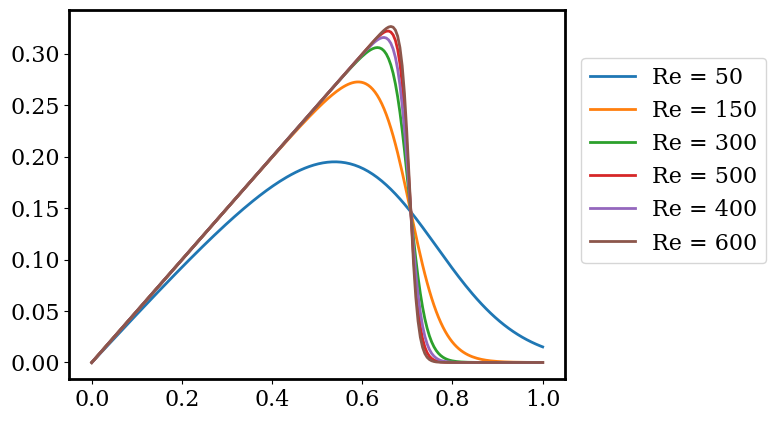

In [5]:
## Generate shifted solutions using
## snapshots at an intermediate time
## and visualize them

uh_shift = {}

for r, Re in enumerate(Re_list):
    uh_shift[r] = uh[r]['burgers'][:,int(Nt//2)] 
    plt.plot(xx,uh_shift[r], label='Re = %d'%Re)
    
plt.legend(bbox_to_anchor=(1.01, 0.9))


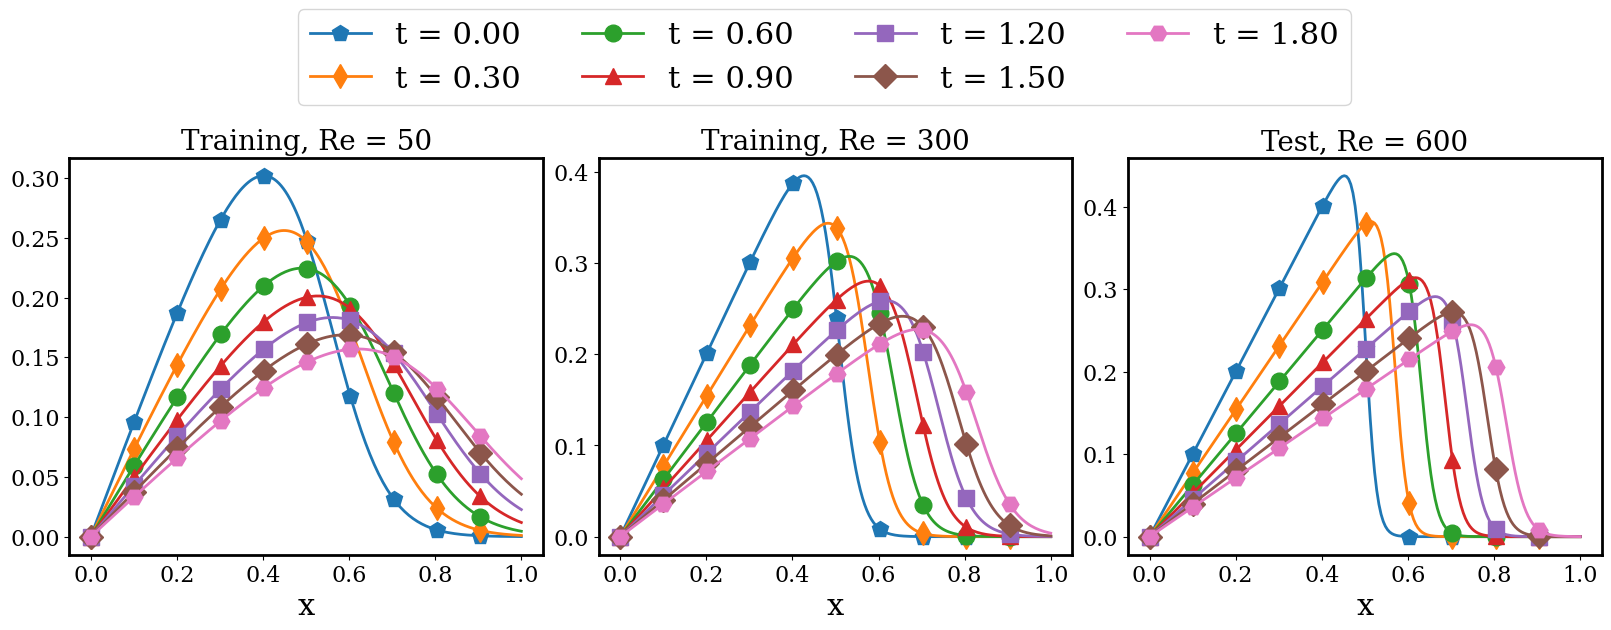

In [6]:
plot_list = [50,300,600]

fig, ax = plt.subplots(nrows=1,ncols=int(len(plot_list)),figsize=(16,5),constrained_layout=True)  


param_num = len(plot_list)
ncols = int(np.ceil(len(plot_list)/2))
for r,Re in enumerate(plot_list):
    rnum = r//ncols ; cnum = r%(ncols)
    
    for it in np.arange(0,Nt,75):
        if r == 0:
            ax[r].plot(xx,uh[r]['burgers'][:,it],label='t = %.2f'%(tt[it]),marker=next(markers),markevery=20)
        else:
            ax[r].plot(xx,uh[r]['burgers'][:,it],marker=next(markers),markevery=20)

    ax[r].set_xlabel('x', fontsize=22)  
    if r>1:
        ax[r].set_title('Test, Re = %d'%Re)
    else:
        ax[r].set_title('Training, Re = %d'%Re)

fig.legend(ncol=4,bbox_to_anchor=(0.85,1.26),fontsize=22)

# plt.savefig(fig_dir+'Burgers1D_param_snapshots.png',dpi=300,bbox_inches='tight')


In [7]:
## Compute SVD

S, S_mean, Phi, sing, W = {},{},{},{},{}
nw, U_r = {},{}

for r, Re in enumerate(Re_list):
    print("Computing SVD for Re = %d"%Re)
    S[r], S_mean[r], Phi[r], sing[r], W[r] = du.compute_pod_multicomponent(uh[r])
    nw[r], U_r[r] = du.compute_trunc_basis(sing[r], Phi[r], eng_cap = 0.999)

Computing SVD for Re = 50
burgers truncation level for 99.9% = 3, \sigma_4 = 0.02752738597871487
Computing SVD for Re = 150
burgers truncation level for 99.9% = 5, \sigma_6 = 0.1257067891736736
Computing SVD for Re = 300
burgers truncation level for 99.9% = 8, \sigma_9 = 0.23057420685057595
Computing SVD for Re = 500
burgers truncation level for 99.9% = 11, \sigma_12 = 0.33655306536181434
Computing SVD for Re = 400
burgers truncation level for 99.9% = 9, \sigma_10 = 0.3526445766535485
Computing SVD for Re = 600
burgers truncation level for 99.9% = 13, \sigma_14 = 0.3165665059588932


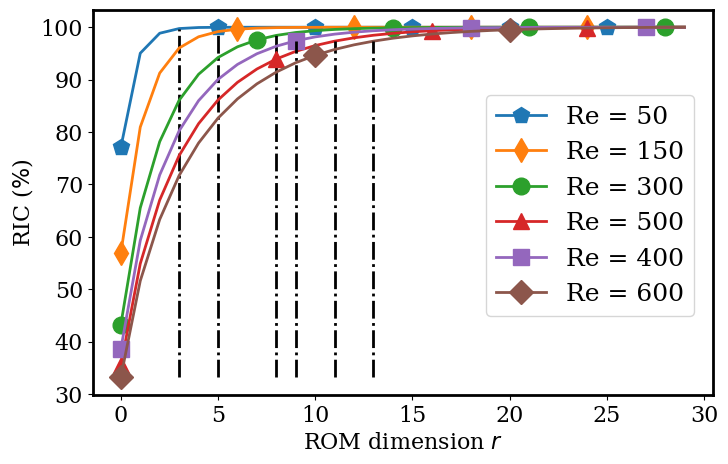

In [8]:
## Visualize SVD

fig = plt.figure(figsize=(8,5))
sing_min = np.zeros(len(Re_list))
sing_max = np.zeros(len(Re_list))
tr_mark = 30
for r, Re in enumerate(Re_list):
    sing_max[r] = np.cumsum(sing[r]['burgers'][:tr_mark])[-1]
    sing_min[r] = np.cumsum(sing[r]['burgers']).min()/sing_max[r]
    
for r, Re in enumerate(Re_list):
    mskip = sing[r]['burgers'].size//40 + r
    tmp = np.cumsum(sing[r]['burgers'][:tr_mark])/sing_max[r]
    plt.plot(100*tmp, label='Re = %d'%(Re),
                             marker=next(markers), markevery=mskip)
    plt.vlines(nw[r]['burgers'], 100*sing_min.min(),100*tmp[nw[r]['burgers']],
               color='k',linestyle='dashdot')

    plt.xlabel('ROM dimension $r$')
    plt.ylabel('RIC ($\%$)')
plt.legend(fontsize=18,bbox_to_anchor=(0.99,0.81))

# plt.savefig(fig_dir+'Burgers1D_PODmodes.png',dpi=300,bbox_inches='tight')